In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import widgets
from IPython.display import display, clear_output
import pickle
import pandas_datareader as pdr
from tqdm.notebook import tqdm as log_progress

In [2]:
from Forecaster import Forecaster

In [3]:
def get_monthly_futures(start,n_periods):
    """ Returns a list of future dates to forecast for in the form 'yyyy-mm-01'
        Parameters: start : str
                        a date in the form 'yyyy-mm-01'
                    n_periods : int 
                        how many periods to go out
                        the size of the resulting list
    """
    first_month = int(start.split('-')[1])
    months = [first_month + i for i in range(n_periods)]
    years = [int(start.split('-')[0])] * n_periods
    while max(months) > 12:
        for i, m in enumerate(months):
            if m > 12:
                months[i] -= 12
                years[i] += 1
    return ['{}-{:02d}-01'.format(y,m) for y, m in zip(years,months)]

def get_regressors(futures,month_lags=24,year_lags=0):
    """ returns a dataframe of external regressors from FRED
        extracts the recession indicator and maps to length specified in recession_length
        adds month and year lags
        adds an inidcator of when the last recession occured
        adds a time trend
        Parameters: futures : list
                        a list of dates in format YYYY-mm-01
                        if there is overlap between the earlier dates and what is extracted from FRED, that will be handled in the function
                    recession_length : int, default 18
                        the total assumed length of the recession (last one began 10/1/2019)
                        this does not take into account the amount of months the recession has already gone
                    month_lags : int, default 24
                        the amount of month lags you want added of the recession inidcator from FRED
                        must be at least 1
                    year_lags : int, default 0
                        the amount of year lags you want added of the recession inidcator from FRED
    """
    externals = pdr.get_data_fred(['JHDUSRGDPBR','CPIAUCSL'],start='1900-01-01').reset_index()
    externals = externals[externals['DATE'] >= externals.loc[~externals['JHDUSRGDPBR'].isnull(),'DATE'].min()]
    externals['JHDUSRGDPBR'].fillna(method='ffill',inplace=True)
    externals = externals[['DATE','JHDUSRGDPBR']]
    futures = pd.to_datetime([d for d in futures if d not in list(externals['DATE'].apply(lambda x: str(x)[:10]))])
    recession_array = 0
    externals_future = pd.DataFrame({'DATE':futures,'JHDUSRGDPBR':recession_array})
    externals = externals.append(externals_future,ignore_index=True,sort=False)
    for i in range(min(1,month_lags),month_lags+1):
        if i == 0:
            break # 0 lags specified
        externals[f'JHDUSRGDPBR_lagMonth_{i}'] = externals['JHDUSRGDPBR'].shift(i)
    for i in range(min(1,year_lags),year_lags+1):
        if i == 0:
            break # 0 lags specified
        externals[f'JHDUSRGDPBR_lagYear_{i}'] = externals['JHDUSRGDPBR'].shift(i*12)
    externals['LastRecession'] = externals[['DATE','JHDUSRGDPBR','JHDUSRGDPBR_lagMonth_1']].apply(lambda x: str(x[0]) if (x[1] == 1) & (x[2] == 0) else None, axis=1)
    externals['LastRecession'].fillna(method='ffill',inplace=True)
    externals['t'] = range(externals.shape[0])
    return externals.copy()

def pickle_out(obj):
    """ writes out forecast results as a pickle file to the pickled folder
        Parameters: obj : any data type
                        the object to be written out -- this will be a Forecaster object
    """
    with open('pickled/AllStatesForecasts-{0}.pickle'.format(str(datetime.datetime.now()).split('.')[0].replace(':','')),'wb') as f:
        pickle.dump(obj,f)

def pickle_in(which='latest'):
    """ reads a pickle object saved in the pickled folder
        Parameters: which : str, default "latest"
                        if "latest", will read in the most recently created file in the pickled folder
                        any other argument should be a datetime-like str and correspond with a file name in the pickled folder
                        ex. to extract the AllStatesForecast-2020-09-11 121129.pickle file, this would be "2020-09-11 121129"
    """
    if which == 'latest':
        most_recent_file = max([f for f in os.listdir('pickled')])
        f= open(f'pickled/{most_recent_file}','rb')
    else:
        f= open(f'pickled/AllStatesForecasts-{which}.pickle','rb')
    x = pickle.load(f)
    f.close()
    return x

def visualize():
    """ visualize the forecast results
        leverages Jupyter widgets
        relies on the ExternalsData object type
        add new forecast names to the model_options list
        Parameters: top : int
                        the top number of models (by evaluated rmse) to display
    """
    def display_user_selections(states_selection,ei_selection,models_selection):
        """ displays graphs with seaborn based on what user selects from dropdown menus
        """
        sns.set(rc={'figure.figsize':(18,10)})
        selected_data = forecasts[f'{states_selection}{ei_selection}']
        selected_data.plot(models=f'top_{models_selection}',metric='rmse',print_metric=True,plot_fitted=True)

    def on_button_clicked(b):
        """ passes the user options to the display_user_selections function after the button is pressed
        """
        states_selection = states_dropdown.value
        ei_selection = ei_dropdown.value
        models_selection = models_dropdown.value
        with output:
            clear_output()
            display_user_selections(states_selection,ei_selection,models_selection)
    
    states_dropdown = widgets.Dropdown(options=states, description = 'State')
    ei_dropdown = widgets.Dropdown(options=['SLIND','PHCI','UR'], description = 'Indicator')
    models_dropdown = widgets.Dropdown(options=range(1,15), description = 'No. Models')

    # never changes
    button = widgets.Button(description="Show Forecast")
    output = widgets.Output()

    display(states_dropdown,ei_dropdown,models_dropdown)
    display(button, output)
    
    button.on_click(on_button_clicked)   

In [4]:
# a list of state abbreviations
states = [e.replace('"','') for e in open('state_abb.txt').read().split('\n')]
# a list of future dates
futures = get_monthly_futures('2020-02-01',33)

In [5]:
# whether or not to rerun the forecast - if false, will read in a pickled forecast
rerun = False
if rerun:
    externals = get_regressors(futures)
    forecasts = {}
    for s in log_progress(states):
        for ei in ('SLIND','PHCI','UR'):
            f = Forecaster()
            if ei == 'PHCI':
                f.get_data_fred(f'{s}{ei}',i=2)
            else:
                f.get_data_fred(f'{s}{ei}',i=1)
            f.process_xreg_df(externals,date_col='DATE')
            f.forecast_mlp(test_length=12,hyper_params={'hidden_layer_sizes':(10,50,),'solver':'lbfgs','activation':'relu'})
            f.forecast_mlr(test_length=12)
            f.forecast_ridge(test_length=12,alpha=10)
            f.forecast_lasso(test_length=12,alpha=.05)
            f.forecast_svr(test_length=12,hyper_params={'kernel':'linear','C':0.05,'epsilon':1.25})
            f.forecast_auto_arima(test_length=12,Xvars='top_2',call_me='arima_2_vars')
            f.forecast_auto_arima(test_length=12,Xvars=None)
            f.forecast_auto_hwes(test_length=12)
            f.forecast_tbats(test_length=12)
            f.forecast_ets(test_length=12)
            f.forecast_prophet(test_length=12,Xvars='all')
            f.forecast_prophet(test_length=12,Xvars='top_2',call_me='prophet_2_reg')
            f.forecast_prophet(test_length=12,call_me='prophet_no_reg')
            f.forecast_average(models='top_4',metric='rmse')
            forecasts[f'{s}{ei}'] = f
    pickle_out(forecasts)
else:
    forecasts = pickle_in('latest')

In [6]:
with open('forecast_info.csv','w') as f:
    # column headers
    f.write(';'.join([
        'symbol',
        'state',
        'ei',
        'series_start_date',
        'series_end_date',
        'n_obs',
        'model_form',
        'model_nickname',
        'externals',
        'holdout_periods',
        'rmse',
        'last_predicted_test_value',
        'last_actual_test_value',
        'is_best_model'
    ]))
    # data
    for k, dat in forecasts.items():
        dat.set_best_model()
        for m in dat.forecasts:
            f.write('\n')
            f.write(';'.join([
                dat.name,
                dat.name[:2],
                dat.name[2:],
                str(dat.current_dates[0]),
                str(dat.current_dates[-1]),
                str(len(dat.y)),
                dat.info[m]['model_form'],
                m,
                str(dat.feature_importance[m].index.to_list()) if m in dat.feature_importance.keys() else 'None',
                str(dat.info[m]['holdout_periods']),
                str(dat.rmse[m]),
                str(list(dat.info[m]['test_set_predictions'])[-1]),
                str(dat.info[m]['test_set_actuals'][-1]),
                '1' if m == dat.best_model else '0'
            ]))

forecast_info = pd.read_csv('forecast_info.csv',sep=';')

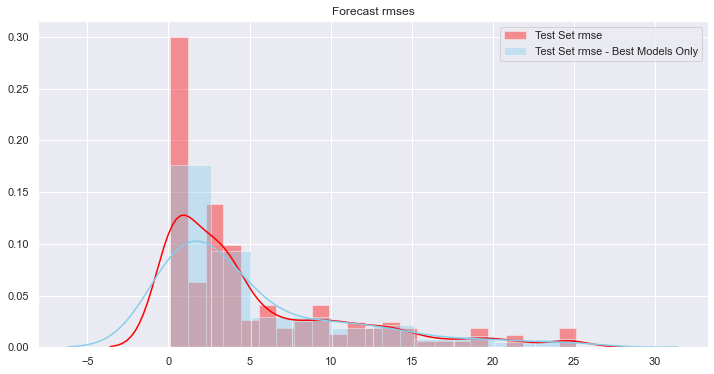

In [7]:
forecast_info1 = forecast_info.replace([np.inf, -np.inf], np.nan).dropna()
forecast_info2 = forecast_info1.loc[(forecast_info1['is_best_model'] == 1)]

sns.set(rc={'figure.figsize':(12,6)})
sns.distplot(forecast_info1['rmse'], color='red', label='Test Set rmse')
sns.distplot(forecast_info2['rmse'], color='skyblue', label='Test Set rmse - Best Models Only')
plt.xlabel('')
plt.title('Forecast rmses')
plt.legend()
plt.show()

In [8]:
print('all models median rmse:',forecast_info1['rmse'].median())
print('best models median rmse:',forecast_info2['rmse'].median())

all models median rmse: 3.0788570429442457
best models median rmse: 3.0515823945075704


In [9]:
visualize()

Dropdown(description='State', options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID',…

Dropdown(description='Indicator', options=('SLIND', 'PHCI', 'UR'), value='SLIND')

Dropdown(description='No. Models', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14), value=1)

Button(description='Show Forecast', style=ButtonStyle())

Output()